In [1]:
# Importing Libraries and Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import yfinance as yf

In [2]:
# Load in 2min SPY data and preview data 

ticker = ['SPY'] #Change ticker symbol to review any instrument in yahoo finance 
data_df = yf.download(ticker, interval = '2m', start = "2022-09-19", end = "2022-11-04")
#2 min data only available in last 60 days 

data = data_df.drop(columns = ['Volume', 'Open', 'High', 'Low', 'Adj Close'])
data.head()

[*********************100%***********************]  1 of 1 completed


,Close
Datetime,
2022-09-26 09:30:00,367.369995
2022-09-26 09:32:00,367.869995
2022-09-26 09:34:00,368.089996
2022-09-26 09:36:00,368.220001
2022-09-26 09:38:00,367.894989


In [3]:
# Review dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5649 entries, 2022-09-26 09:30:00 to 2022-11-03 15:58:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5649 non-null   float64
dtypes: float64(1)
memory usage: 88.3 KB


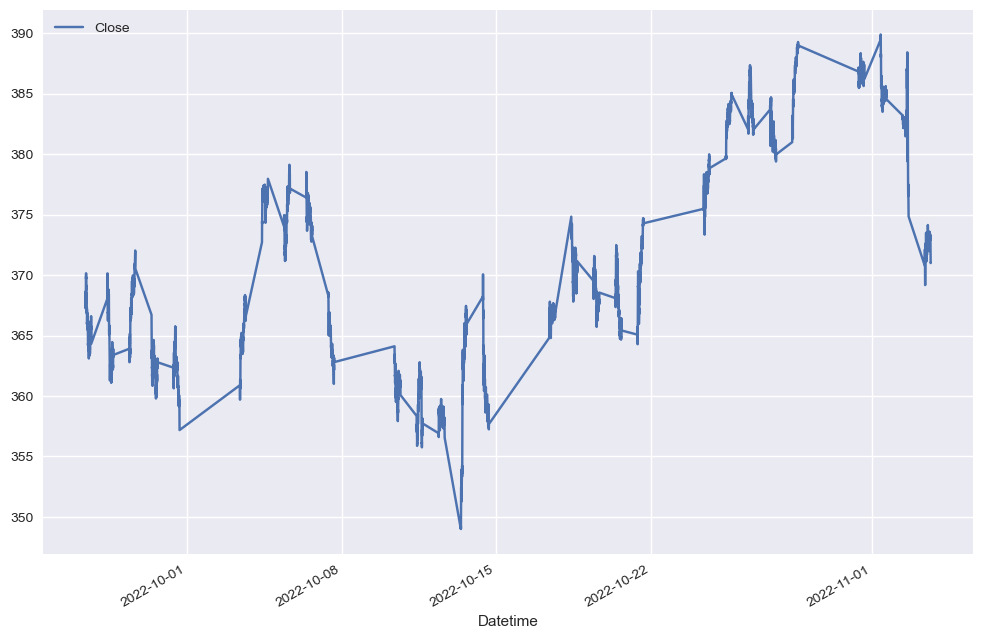

In [4]:
# Plot buy and hold returns strategy 

data.plot(figsize = (12, 8))
plt.show()

In [5]:
# Use shift function to create a column for returns and review 
#data["returns"] = np.log(data.div(data.shift(1)))
data['daily_returns'] = data.Close.pct_change()
data.head()

,Close,daily_returns
Datetime,,
2022-09-26 09:30:00,367.369995,NaN
2022-09-26 09:32:00,367.869995,0.001361
2022-09-26 09:34:00,368.089996,0.000598
2022-09-26 09:36:00,368.220001,0.000353
2022-09-26 09:38:00,367.894989,-0.000883


In [6]:
# Bollinger Bands Trading Strategy 

# Set SMA and standard deviations 
SMA = 30
dev = 2


# Creating column to hold SMA
data["SMA"] = data["Close"].rolling(SMA).mean()

# Creating the lower band 
data["Lower"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev 

# Creating the upper band
data["Upper"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev 

# Creating a column for distance between closing price and the SMA
data["distance"] = data.Close - data.SMA # helper Column

# Creating a column to add a 1 if oversold to go long 
data["position"] = np.where(data.Close < data.Lower, 1, np.nan) # 1. oversold -> go long

# Adding a -1 to the 'position' row if overbought to go short 
data["position"] = np.where(data.Close > data.Upper, -1, data["position"]) # 2. overbought -> go short

# Adding a 0 to the 'position' column to close position when passes SMA 
data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])

# If 1-3 isn't met the previous position is held 
data["position"] = data.position.ffill().fillna(0) # where 1-3 isn´t applicable -> hold previous position

# Creating a column for strategy returns
data["strategy_returns"] = data.position.shift(1) * data["daily_returns"]

In [7]:
data.dropna(inplace=True)

In [8]:
data.head()

,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns
Datetime,,,,,,,,
2022-09-26 10:28:00,369.820007,0.000351,368.531830,366.846767,370.216893,1.288177,0.0,0.0
2022-09-26 10:30:00,369.570099,-0.000676,368.605167,366.937928,370.272405,0.964932,0.0,-0.0
2022-09-26 10:32:00,369.390015,-0.000487,368.655834,366.988658,370.323010,0.734181,0.0,-0.0
2022-09-26 10:34:00,369.011108,-0.001026,368.686538,367.028580,370.344496,0.324571,0.0,-0.0
2022-09-26 10:36:00,369.359985,0.000945,368.724537,367.058589,370.390485,0.635448,0.0,0.0


In [9]:
from math import floor 
from termcolor import colored as cl
spy_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(spy_ret)):
    returns = spy_ret['returns'][i]*data['position'][i]
    bb_strategy_ret.append(returns)
bb_strat_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0: 'bb_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/data['Close'][-1])
bb_investment_ret = []

for i in range(len(bb_strat_df['bb_returns'])):
    returns = number_of_stocks*bb_strat_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0: 'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)

print(cl('Profit gained from the BB strategy by investing $100k in SPY : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB strategy : {}%'.format(profit_percentage), attrs = ['bold']))
    



Profit gained from the BB strategy by investing $100k in SPY : 7968.92
Profit percentage of the BB strategy : 7%


In [10]:
data["cum_returns"] = data["daily_returns"].cumsum().apply(np.exp)
data["cum_return_strategy"] = data["strategy_returns"].cumsum().apply(np.exp)

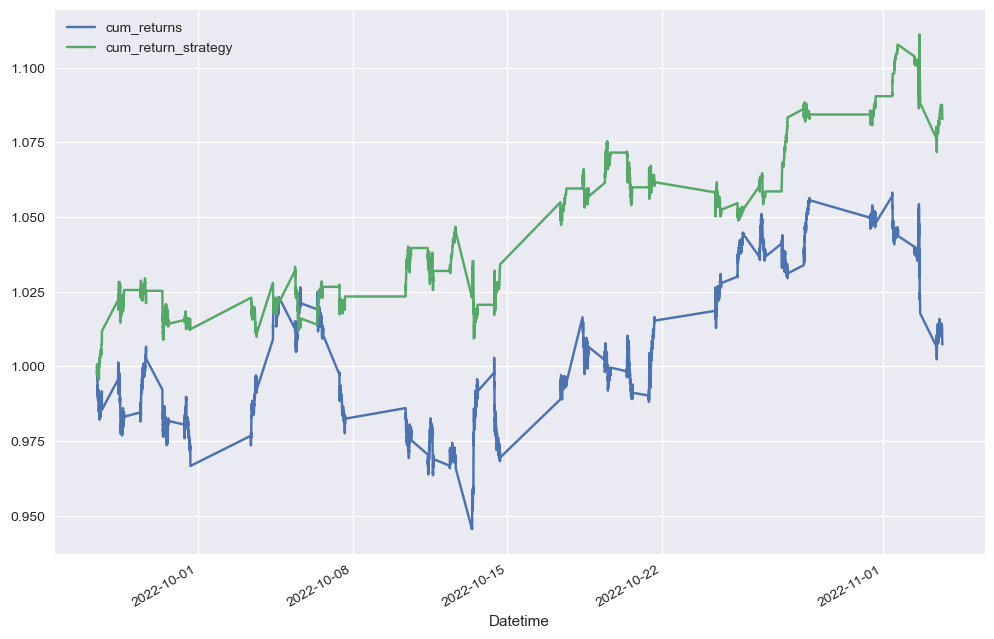

In [11]:
data[["cum_returns", "cum_return_strategy"]].plot(figsize = (12 , 8))
plt.show()

In [12]:
data.head()

,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns,cum_returns,cum_return_strategy
Datetime,,,,,,,,,,
2022-09-26 10:28:00,369.820007,0.000351,368.531830,366.846767,370.216893,1.288177,0.0,0.0,1.000351,1.0
2022-09-26 10:30:00,369.570099,-0.000676,368.605167,366.937928,370.272405,0.964932,0.0,-0.0,0.999676,1.0
2022-09-26 10:32:00,369.390015,-0.000487,368.655834,366.988658,370.323010,0.734181,0.0,-0.0,0.999189,1.0
2022-09-26 10:34:00,369.011108,-0.001026,368.686538,367.028580,370.344496,0.324571,0.0,-0.0,0.998164,1.0
2022-09-26 10:36:00,369.359985,0.000945,368.724537,367.058589,370.390485,0.635448,0.0,0.0,0.999108,1.0


In [13]:
data_test = pd.DataFrame(data['Close'])
data_test.to_csv('df.csv')

In [14]:
from itertools import product
import MeanRevBacktester as MeanRev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import yfinance as yf

In [15]:
trading_costs = 0.00007

In [16]:
tester = MeanRev.MeanRevBacktester('Close', 30, 2, "2022-09-19", "2022-11-04", trading_costs)

In [17]:
tester

MeanRevBacktester(symbol = Close, SMA = 30, dev = 2, start = 2022-09-19, end = 2022-11-04)

In [18]:
tester.test_strategy()

(1.059237, 0.046047)

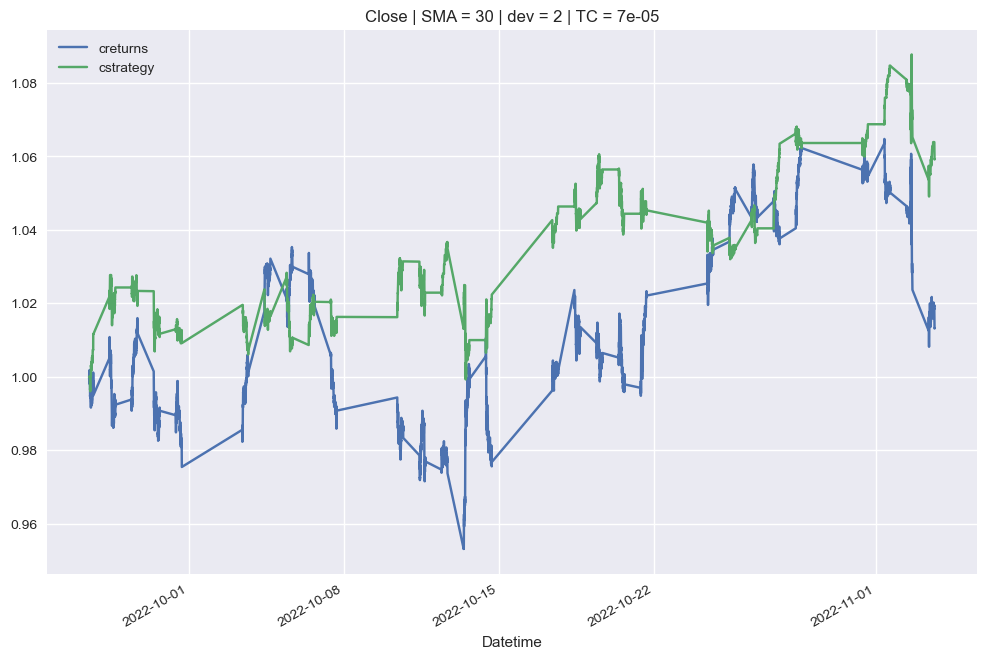

In [19]:
tester.plot_results()

In [20]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

((60, 1), 1.085874)

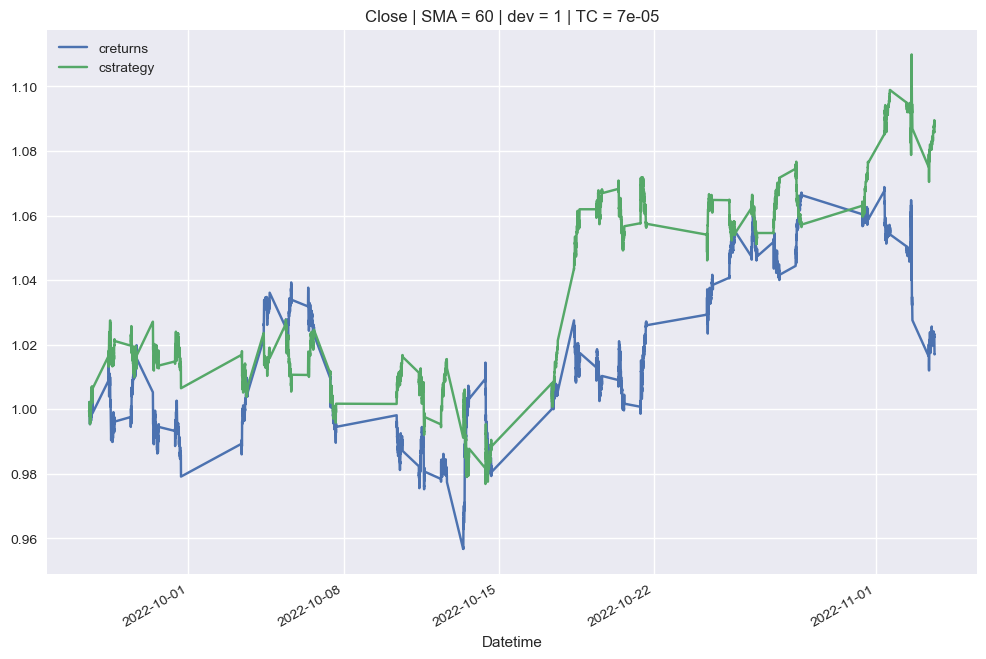

In [21]:
tester.plot_results()

In [22]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Datetime,,,,,,,,,,,
2022-09-26 12:28:00,364.665009,-0.000343,366.963707,365.704561,368.222854,-2.298699,1.0,-0.000343,0.0,0.999657,0.999657
2022-09-26 12:30:00,364.579987,-0.000233,366.880539,365.631706,368.129372,-2.300552,1.0,-0.000233,0.0,0.999424,0.999424
2022-09-26 12:32:00,364.204987,-0.001029,366.794122,365.542489,368.045754,-2.589135,1.0,-0.001029,0.0,0.998396,0.998396
2022-09-26 12:34:00,364.239990,0.000096,366.714603,365.454676,367.974530,-2.474613,1.0,0.000096,0.0,0.998492,0.998492
2022-09-26 12:36:00,364.359985,0.000329,366.631270,365.383987,367.878552,-2.271284,1.0,0.000329,0.0,0.998821,0.998821
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-03 15:50:00,371.635010,-0.000955,372.831664,372.364782,373.298546,-1.196654,1.0,-0.000955,0.0,1.018764,1.087703
2022-11-03 15:52:00,371.420013,-0.000579,372.809818,372.308722,373.310913,-1.389804,1.0,-0.000579,0.0,1.018175,1.087074
2022-11-03 15:54:00,371.225006,-0.000525,372.782734,372.241538,373.323931,-1.557728,1.0,-0.000525,0.0,1.017640,1.086503


In [23]:
tester.results_overview

,SMA,dev,performance
0,25,1,0.985382
1,25,2,1.017060
2,25,3,0.963284
3,25,4,0.993438
4,26,1,0.993872
...,...,...,...
295,98,4,1.029652
296,99,1,1.023482
297,99,2,1.022070
298,99,3,1.077381


In [24]:
tester.results_overview.nlargest(10, "performance")

,SMA,dev,performance
140,60,1,1.085874
278,94,3,1.082704
274,93,3,1.081838
298,99,3,1.077381
294,98,3,1.075714
92,48,1,1.074855
136,59,1,1.074618
290,97,3,1.074476
266,91,3,1.072094
270,92,3,1.072094


In [25]:
tester.results_overview.nsmallest(10, "performance")

,SMA,dev,performance
14,28,3,0.962932
2,25,3,0.963284
18,29,3,0.967605
10,27,3,0.968470
6,26,3,0.974055
0,25,1,0.985382
50,37,3,0.985857
77,44,2,0.988960
8,27,1,0.989963
89,47,2,0.992769
